# Similar-sized Collision Outcome Map in Python

Collision outcome map from Leinhardt & Stewart, ApJ, 2012 with option to scale velocity axis by impact probability (see Stewart & Leinhardt, ApJ, 2012).

Compare results to https://sarahtstewart.net/resources/collision/<br>
The online javascript calculator does not include the graze-and-merge regime.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from woma.misc import glob_vars as gv
R_earth = gv.R_earth #6.371e6   # m
M_earth = gv.M_earth #5.9724e24  # kg 
G = 6.67408e-11  # m^3 kg^-1 s^-2

#matplotlib.rc('xtick', labelsize=22) 
#matplotlib.rc('ytick', labelsize=22)
#matplotlib.rcParams["figure.facecolor"] = 'white'
#matplotlib.rcParams["font.family"] = 'Times New Roman'

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 22})
if 1:
    # use serif fonts; otherwise default matplotlib fonts
    plt.rcParams.update({'font.family': 'Times New Roman'})
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.rm'] = 'Times New Roman'
    plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
    plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [2]:
# function to scale y-axis by a probability distribution
# vin is an array of V/Vesc values to rescale
# velarr is an array of V/Vesc values used to calc a probability distribution
# ymin,ymax are the vertical scale range on the figure in V/Vesc
# Currently, ymin must be equal to zero
# function returns a y value in terms of a linear [0,ymax] for the scaled value of vin
def velscale(vin,velarr,ymin,ymax):
    nbins = 1000 
    hst,bin_edges=np.histogram(velarr,bins=nbins,range=(ymin,ymax))
    halfbin = bin_edges[1]-bin_edges[0]
    bins = bin_edges[0:-1]+halfbin
    sumarr   = np.zeros(len(hst)) 
    for i in np.arange(len(hst)):
        sumarr[i] = np.sum(hst[0:i])
    sumarr       = sumarr/max(sumarr) #; normalized cumulative probability
    ylinear = np.arange(nbins)/nbins*(ymax-ymin)+ymin
    ypos = np.interp(vin,bins,sumarr) # returns scale y value from 0 to 1
    
    if 1:
        zzz=np.where(vin > ymax)[0]
        if len(zzz)>0:
            ypos[zzz]=1
        zzz=np.where(vin < ymin)[0] # must be zero for now
        if len(zzz)>0:
            ypos[zzz]=0
    ypos = ypos*ymax
    return ypos


In [126]:
# units are cgs
def collisionmap(mu=0.36, cstar=1.9, gamma=0.5, vi=np.array([10e5]), ang=np.array([45]), printit=0, ymax=3, ymin=0, rho=3.0, rt=1000e5, vscale=[], outcomes=[]):
    """
    Simulates collision conditions based on given parameters and plots results.
    
    Parameters:
        mu (float): Material parameter, velocity exponent.
        cstar (float): Material parameter for principal disruption curve.
        gamma (float): Projectile to target mass ratio.
        v_imp (float): Impact velocity in units of cm/s
        ang (float): Impact angle (0-90 degress)
        printit (int): Whether to print computed values.
        ymax (float): Maximum y-axis value for plot in units of vesc
        ymin (float): 0 (not used at this time)
        rho (float): Bulk density of bodies.
        rt (float): Target radius in cm.
        vscale (float array): optional array of impact velocities in units of V/Vesc to generate probability scaled plot
    Outputs:
        mlrmtot (float): mass of largest remnant in units of total mass
        outcome (string): collision outcome regime
    """

    # SET UP EQUAL PROBABILITY ANGLE ARRAYS
    thetaarr = np.arange(181)/180.*np.pi/2.
    probarr  = np.sin(thetaarr)*np.cos(thetaarr)
    sumarr   = np.zeros(len(thetaarr)) 
    for i in np.arange(len(thetaarr)):
        sumarr[i] = np.sum(probarr[0:i])
    sumarr       = sumarr/max(sumarr) #; normalized cumulative probability
    nbarr        = 200  #integer; defines resolution of the x-axis
    kkk          = np.arange(nbarr)/nbarr # equal spacing 0 to 1 for x axis
    thetaevenarr = np.interp(kkk,sumarr, thetaarr) #thetaarr,sumarr,kkk)
    barr         = np.sin(thetaevenarr) #; array holding impact parameter for x-axis scaled by probability
    bscale       = kkk
    # arrays to help plot areas
    zeroarr = np.zeros(nbarr)
    ymaxarr = np.zeros(nbarr)+ymax # ymax is input parameter in units of Vi/Vesc

    # constants in CGS
    pi = np.pi
    G = 6.67408e-8  # Gravitational constant in cgs units
    rho1 = 1.0 # g/cm3
 
    # Compute masses from radii and bulk density
    mt = (4.0 * pi * rho / 3.0) * rt**3  # Target mass in g
    mp = gamma * mt  # Projectile mass in g
    mtot = (1.0 + gamma) * mt  # Total mass in g
    mred = mp * mt / mtot # reduced mass
    third = 1.0 / 3.0
    rp = (mp / (4.0 / 3.0 * pi * rho))**third  # Projectile radius cm
    rc1 = ((mt * (1.0 + gamma)) / (4.0 / 3.0 * pi*rho1))**third  # Critical radius in cm
    rtot = rp+rt
    
    # Escape velocities
    vesc = np.sqrt(2.0 * G * mtot / (rt + rp)) # cm/s mutual escape velocity
    print(vesc)
    # Principal disruption curve values
    qg = (1.0 / 8.0) * (32.0 * pi * cstar / 5.0)**(3.0 * mu / 2.0)
    # critical disruption velocity for head-on equal mass normalized to rho=1 g/cm3 in cm/s
    vequal = np.sqrt(32.0 * pi * cstar / 5.0 * rho1 * G) * rc1
    # critical Q*RD for head-on equal mass normalized to rho=1 g/cm3 in erg/g
    qequal = cstar * (4.0 / 5.0) * pi * rho1 * G * rc1**2

     # Compute impact outcomes
    bcrit = rt / (rtot)
    bcrit_ind = np.interp(bcrit,barr,bscale) # correct scaled index for ang array input
    lll = (1-barr)*(rtot)
    minteract = rho*(pi*rp*np.power(lll,2)-(pi/3)*np.power(lll,3))
    alpha = minteract/mp
    # correct alpha for cases where the entire projectile strikes the target
    for i in range(nbarr):
        if barr[i]*rtot+rp < rt:
            alpha[i]= 1
    mredalpha = mp*alpha*mt/(mt+mp*alpha) # g
    mtotinteract = mt+mp*alpha
    vescinteract  = np.sqrt(2*G*mtotinteract/rtot) # cm/s 
    # correct for actual mass ratio and impact angle
    # new method 10/29/11 calculate values for b=0
    qx = np.power( np.power(gamma+1,2) / (4*gamma) , 2/(3*mu) - 1 )
    qmassratio = qx*cstar*4*pi*rho1*G/5*rc1*rc1
    vmassratio = np.power( (2 * np.power(gamma+1,2) * qg * np.power(rho1*G,3*mu/2) * np.power(rc1,3*mu) / gamma), 1/(3*mu) )
    # correct for impact angle
    qangle1 = qmassratio*mred/mredalpha # defined for any b erg/g
    vangle1 = np.sqrt(qangle1*mtot/(0.5*mred)) # defined for any b cm/s
    qangle = qangle1*np.power((vangle1/vmassratio), 2-3*mu) # erg/g
    vangle = np.sqrt( qangle*mtot/(0.5*mred) ) # cm/s

    #figure out when the target is eroded largest remanant = target mass
    mftarg = mt/mtot
    qmftarg = ( (mftarg-0.5)/(-0.5)+1)*qangle
    vmftarg = np.sqrt(qmftarg*mtot/(0.5*mred))

    # calculate result for catastrophic disruption largest remnant = half total mass
    mfhalf = 0.5 # in units of mtot
    qmfhalf = ( (mfhalf-0.5)/(-0.5)+1)*qangle
    vmfhalf = np.sqrt(qmfhalf*mtot/(0.5*mred))

    # Calculate Kokubo & Genda 2010 graze-and-merge boundary
    ggg        = (1.-gamma)/(1.+gamma)
    vcritkg = 2.43*ggg*(1.-barr)**(5./2.) -0.0408*ggg +1.86*(1.-barr)**(5./2.) + 1.08 # in units of vesc (with real radii)
    zzz = np.where(barr > bcrit)[0]
    vone = np.zeros(len(zzz))+1
    vymax = np.zeros(len(zzz))+ymax
    
    # make figure with linearly scaled velocity axis
    #plt.figure()
    fig, ax1 = plt.subplots(layout='constrained')
    # y axis is 0 to ymax in V/Vesc
    vzero = np.zeros(nbarr)
    ax1.fill_between(bscale,vzero,vescinteract/vesc,color='royalblue',alpha=0.7,label='Perfect merging')
    zzz = np.where(barr > bcrit)[0]
    ax1.fill_between(bscale[zzz],vescinteract[zzz]/vesc,vcritkg[zzz],color='limegreen',alpha=0.7,label='Graze & merge')
    ax1.fill_between(bscale[zzz],vcritkg[zzz],vmftarg[zzz]/vesc,color='lightgreen',alpha=0.7,label='Hit & run')
    ax1.plot([bcrit_ind,bcrit_ind],[1,vmftarg[zzz[0]]/vesc],linewidth=2,color='red')

    zzz = np.where(barr < bcrit)[0]
    ax1.fill_between(bscale[zzz],vescinteract[zzz]/vesc,vmftarg[zzz]/vesc,color='deepskyblue',alpha=0.7,label='Partial accretion')
    
    ax1.plot(bscale,vmftarg/vesc, label = 'Target erosion', linewidth=2,color='blue') #label=f"v_imp={vi}, gamma={gamma}")
    ax1.plot(bscale,vmfhalf/vesc, label = '$0.5M_{tot}$ remaining',linewidth=3,color='black') #label=f"v_imp={vi}, gamma={gamma}")
    ax1.legend()

    # annotate the outcome       
    outcome_map = {
        1: "super-catastrophic disruption (Mlr < 0.1Mtot)",
        2: "partial erosion (0.1Mtot to Mtarget)",
        3: "partial accretion (Mtarget to Mtarget+Mprojectile)",
        4: "perfect merging (Mtarget+Mprojectile)",
        5: "graze-and-merge",
        6: "hit-and-run"
    }
    
    outcome_label = {
        1: "Super-catastrophic disruption",
        2: "Partial erosion",
        3: "Partial accretion",
        4: "Perfect merging",
        5: "Graze & merge",
        6: "Hit & run"
    }
    
    outcome_marker = {
        1: 'x',
        2: 'X',
        3: 'o',
        4: 's',
        5: 'o',
        6: 'D'
    }

    outcome_fill = {
        1: 'k',
        2: 'none',
        3: 'k',
        4: 'k',
        5: 'none',
        6: 'none'
    }
    viarr = vi
    angarr=ang
    binscalearr=np.zeros(np.size(vi))
    cflagarr =np.zeros(np.size(vi))
    for ii in range(np.size(vi)):
        ang=angarr[ii]
        vi=viarr[ii]
        
        # calculate results for input case(s)
        # Loop over the input cases [vi,ang] for fixed c*, mu, gamma
        bb = np.sin(ang * pi / 180.0)  # Convert angle degrees to impact parameter b
        bindexarr = np.arange(nbarr)
        bb_index = np.interp(bb,barr,bindexarr).astype(int) # correct scaled index for ang array input
        #print('bb, bb_index, vi, vescinteract= ',bb,bb_index,vi,vescinteract[bb_index])
        binscale = bscale[bb_index] #np.interp(ang/180.*np.pi/2.,thetaevenarr,barr)
        binscalearr[ii]=binscale
        
        if 1:
            cflag=0
            mlrmtot=0
            # calculate the specific impact
            if (bb < bcrit):
                # non-grazing regime
                #print('Non-grazing regime')
                qsim = (0.5 * (mp * mt / (mtot)) * vi**2) / (mtot) # v in units of cm/s
                mlrmtot = -0.50 * (qsim / qangle[bb_index] - 1.0) + 0.5
                cflag = 3 # start assuming partial accretion
                if (mlrmtot < mt/mtot):
                    cflag = 2 # partial erosion
                if (mlrmtot > 0.99):
                    mlrmtot = 1
                    cflag = 4 # perfect merging
                if (qsim/qangle[bb_index] > 1.8):
                    # supercatastrophic case
                    eta=-1.5
                    mlrmtot = (0.1/np.power(1.8,eta) * np.power(qsim/qangle[bb_index],eta))
                    cflag=1
            else:
                # grazing regime
                #print('Grazing regime')
                #print(vi,vescinteract[bb_index],vmftarg[bb_index],vmfhalf[bb_index])
                if (vi<vescinteract[bb_index]):
                    #print('Vi<vescinteract')
                    mlrmtot=1
                    cflag=4 # perfect merging
                else:
                    if (vi/vesc<vcritkg[bb_index]):
                        #print('Vi<vcritkg[bb_index]')
                        mlrmtot=1
                        cflag=5 # graze and merge
                    else:
                        #print(vi/vesc,vmftarg[bb_index]/vesc)
                        if (vi<vmftarg[bb_index]):
                            #print('Vi<vmftarg')
                            mlrmtot=mt/mtot
                            cflag=6 # hit and run
                        if (vi>=vmftarg[bb_index]):
                            #print('Vi>=vmftarg')
                            # here target erosion in the grazing regime
                            qsim = (0.5 * (mp * mt / (mtot)) * vi**2) / (mtot) # v in units of cm/s
                            mlrmtot = -0.50 * (qsim / qangle[bb_index] - 1.0) + 0.5
                            cflag = 2 # start assuming partial erosion
                            if (qsim/qangle[bb_index] > 1.8):
                                # supercatastrophic case in grazing regime
                                eta=-1.5
                                mlrmtot = (0.1/np.power(1.8,eta) * np.power(qsim/qangle[bb_index],eta))
                                cflag=1 
            
            if len(outcomes)==0:
                cflagarr[ii]=cflag
            else:
                cflagarr[ii]=outcomes[ii]
            cflag=cflagarr[ii]
            
            outcome = outcome_map.get(cflag, "Unknown")
        else:
            mlrmtot=1
            outcome = 'test'
    
        # Plot results
        angles = np.linspace(0, 90, 100)
        velocity_scale = vi * np.exp(-mu * angles / 90)
        
    
        # plot points requested for calculation
        
        ax1.plot(binscale,vi/vesc,'x',markersize=10,color='k',marker=outcome_marker.get(cflag,'o'),
                 markerfacecolor=outcome_fill.get(cflag,'k'))
        #print('binscale,vi/vesc,vi,vsec=',binscale,vi/vesc,vi,vesc)
    
    ax1.set_xlabel("Probability-scaled impact parameter $b$")
    ax1.set_ylabel("$V_{i}/V_{esc}$")
    ax1.set_ylim(0, ymax) # in units of V/Vesc
    ax1.set_xticks(np.arange(5)/4, ['0', '0.5',  '0.7', '0.86','1'])  # Set text labels.
    sax = ax1.secondary_xaxis('top')
    sax.set_xticks(np.arange(5)/4, ['0', '30',  '45', '60','90'])  # Set text labels.
    sax.set_xlabel('Probability-scaled Impact Angle (deg)')
    ax1.set_xlim(0,1)
    #plt.legend()
    fig.savefig('%g_unscaled.pdf'%gamma,bbox_inches='tight')
    fig.show()

    # if requested, plot the collision map with scaled velocity axis
    if len(vscale)==0:
        print('No velocity scaled axis requested.')
    else:
        outcomebool=np.zeros(6)
        ymin=0
        hst,bin_edges=np.histogram(velarr,bins=nbarr,range=(ymin,ymax))
        sumarr   = np.zeros(len(hst)) 
        for i in np.arange(len(hst)):
            sumarr[i] = np.sum(hst[0:i])
        sumarr       = sumarr/max(sumarr) #; normalized cumulative probability
        yprob = np.arange(nbarr)/nbarr*(ymax-ymin)+ymin
        # determine the axis tick labels
        ytickvals = [.75,1,1.1,1.5,2,3,5] # in vesc
        ynormvals = np.interp(ytickvals,yprob,sumarr)*ymax
        ytickstring=[]
        for i in ytickvals:
            ytickstring.append(str(i))

        # make a second plot with velocity-scaled axis
        #ax=plt.figure()
        fig, ax = plt.subplots(layout='constrained')
        # y axis is 0 to ymax in V/Vesc -- scaled to 0 to ymax with probability scaling
        #velscale(vin,velarr,ymin,ymax)
        plt.fill_between(bscale,vzero,velscale(vescinteract/vesc,velarr,0,ymax),color='royalblue',alpha=0.7)#,label='Perfect merging'
        zzz = np.where(barr > bcrit)[0]    
        plt.fill_between(bscale[zzz],velscale(vescinteract[zzz]/vesc,velarr,0,ymax),velscale(vcritkg[zzz],velarr,0,ymax),color='limegreen',alpha=0.7)#,label='Graze & merge'
        plt.fill_between(bscale[zzz],velscale(vcritkg[zzz],velarr,0,ymax),velscale(vmftarg[zzz]/vesc,velarr,0,ymax),color='lightgreen',alpha=0.7)#,label='Hit & run'
        tmp = velscale(vmftarg[zzz]/vesc,velarr,0,ymax)
        tmp1 = velscale(vescinteract[zzz]/vesc,velarr,0,ymax)
        plt.plot([bcrit_ind,bcrit_ind],[tmp1[0],tmp[0]],linewidth=2,color='red')
    
        zzz = np.where(barr < bcrit)[0]
        plt.fill_between(bscale[zzz],velscale(vescinteract[zzz]/vesc,velarr,0,ymax),velscale(vmftarg[zzz]/vesc,velarr,0,ymax),color='deepskyblue',alpha=0.7)#,label='Partial accretion'
        
        plt.plot(bscale,velscale(vmftarg/vesc,velarr,0,ymax), linewidth=2,color='blue') #label=f"v_imp={vi}, gamma={gamma}") #, label = 'Target erosion'
        plt.plot(bscale,velscale(vmfhalf/vesc,velarr,0,ymax),linewidth=3,color='black') #label=f"v_imp={vi}, gamma={gamma}") #, label = '$0.5M_{tot}$ remaining'

        # plot points requested for calculation
        #plt.plot(binscale,velscale(np.asarray([vi/vesc]),velarr,0,ymax),'x',markersize=15,color='black')
        
        for ii in range(np.size(viarr)):
            vi=viarr[ii]
            cflag=cflagarr[ii]
            #print((cflag-1))
            if outcomebool[int(cflag-1)]==0:
                label=outcome_label.get(cflag, "Unknown")+' event'
            else:
                label=None
            outcomebool[int(cflag-1)]+=1
            plt.plot(binscalearr[ii],velscale(np.asarray([vi/vesc]),velarr,0,ymax),markersize=10,color='k',
                     marker=outcome_marker.get(cflag,'o'),markerfacecolor=outcome_fill.get(cflag,'k'),label=label,linewidth=0)
        
        plt.xlabel("Probability-scaled impact parameter $b$")
        plt.ylabel("Probability-scaled $V_{i}/V_{esc}$")
        plt.ylim(0, ymax) # in units of V/Vesc
        plt.xticks(np.arange(5)/4, ['0', '0.5',  '0.7', '0.86','1'])  # Set text labels.
        plt.yticks(ynormvals, ytickstring)  # Set text labels.
        sax = ax.secondary_xaxis('top')
        sax.set_xticks(np.arange(5)/4, ['0', '30',  '45', '60','90'])  # Set text labels.
        sax.set_xlabel('Probability-scaled Impact Angle (deg)')
        plt.legend()
        plt.xlim(0,1)
        #plt.legend()
        plt.savefig('%g_scaled.pdf'%gamma,bbox_inches='tight')
        plt.show()
        
    if printit:
        print(f"Collision with mu={mu}, cstar={cstar}, gamma={gamma}, v_imp={v_imp}, rt={rt}, rhon={rhon}, outcome={outcome}")
    return mlrmtot, outcome
    


## Read in velocity scaling array in units of Vesc

In [40]:
# Raymond giant impact cases used in Stewart & Leinhardt 2012
#with open('velscale.pkl', 'rb') as file:
#    # A new file will be created
#    velarr1 = pickle.load(file)
#print(velarr1)
# Carter et al. simulations from XXX
# these are more energetic; include Grand Tack cases
velarr = np.loadtxt('Postema2024/vscale_collarray.txt')
#print(velarr)

In [83]:
# Read impact parameters to produce v_imp_array
# mass ratio 1:2, gamma=0.5
vesc2=118436.69932560863 #not messing with bulk density values from collisionmap function
[Rtarr2,Riarr2,Mtarr2,Miarr2,vrelarr2,barr2,typearr2]=np.loadtxt('Postema2024/table2.txt',skiprows=1,unpack=True,delimiter=' ')
varr2=vrelarr2*vesc2 #in cm/s
rhoTarr2=Mtarr2*M_earth/(4/3*np.pi*(Rtarr2*R_earth)**3)
rhoiarr2=Miarr2*M_earth/(4/3*np.pi*(Riarr2*R_earth)**3)
rho2avg=(rhoTarr2[0]*Mtarr2[0]+rhoiarr2[0]*Miarr2[0])/(Mtarr2[0]+Miarr2[0])
print(rhoTarr2[0],rhoiarr2[0])
print(rho2avg)

#mass ratio 1:3, gamma=0.3333
vesc3=114923.85628757457
[Rtarr3,Riarr3,Mtarr3,Miarr3,vrelarr3,barr3,typearr3]=np.loadtxt('Postema2024/table3.txt',skiprows=1,unpack=True,delimiter=' ')
varr3=vrelarr3*vesc3 #in cm/s
rhoTarr3=Mtarr3*M_earth/(4/3*np.pi*(Rtarr3*R_earth)**3)
rhoiarr3=Miarr3*M_earth/(4/3*np.pi*(Riarr3*R_earth)**3)
rho3avg=(rhoTarr3[0]*Mtarr3[0]+rhoiarr3[0]*Miarr3[0])/(Mtarr3[0]+Miarr3[0])
print(rhoTarr3[0],rhoiarr3[0])
print(rho3avg)

#mass ratio 1:6, gamma=0.16667
vesc6=112351.32139140146
[Rtarr6,Riarr6,Mtarr6,Miarr6,vrelarr6,barr6,typearr6]=np.loadtxt('Postema2024/table6.txt',skiprows=1,unpack=True,delimiter=' ')
varr6=vrelarr6*vesc6 #in cm/s
rhoTarr6=Mtarr6*M_earth/(4/3*np.pi*(Rtarr6*R_earth)**3)
rhoiarr6=Miarr6*M_earth/(4/3*np.pi*(Riarr6*R_earth)**3)
rho6avg=(rhoTarr6[0]*Mtarr6[0]+rhoiarr6[0]*Miarr6[0])/(Mtarr6[0]+Miarr6[0])
print(rhoTarr6[0],rhoiarr6[0])
print(rho6avg)

3989.935113047201 3857.1202300504783
3945.6634853816263
3989.935113047201 3775.748881196954
3936.428725045602
3989.935113047201 3718.361487033884
3951.1322301669234


118436.69932560863


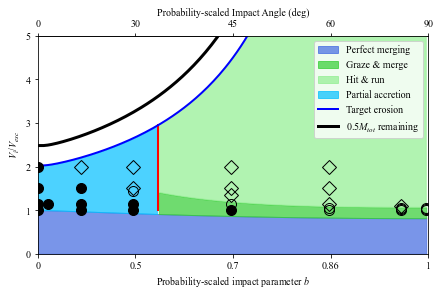

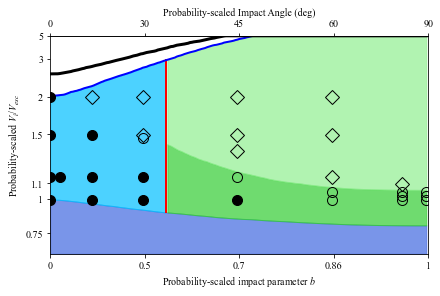

In [102]:
# These are all fixed for a single collision maps
mu = 0.36
cstar = 1.9
gamma = 1/2.
ymax = 5 
ymin=0.
# These are individual impact parameters to be plotted on top of the map
v_imp_values = np.asarray(varr2) #[1e5]  
ang_values= np.asarray(np.arcsin(barr2)*180/np.pi) #np.asarray([45.]) 

#for v, a in zip(v_imp_values, ang_values):
    #mlrmtot, outcome = collisionmap(mu, cstar, gamma, v, a, ymax=ymax, ymin=ymin, vscale=velarr)
    #print(f"Mlr/Mtot: {mlrmtot:.2f}, Outcome: {outcome}")

#rho=rho2avg*1.e-3
mlrmtot, outcome = collisionmap(mu, cstar, gamma, v_imp_values, ang_values, ymax=ymax, ymin=ymin, vscale=velarr, outcomes=typearr2)

114923.85628757457


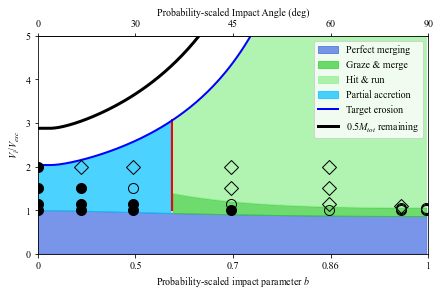

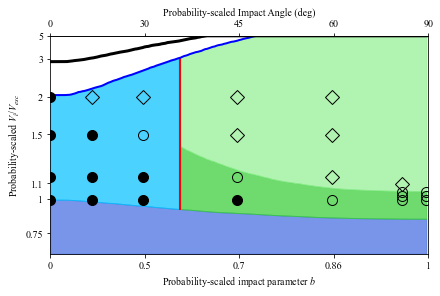

In [103]:
mlrmtot, outcome = collisionmap(mu, cstar, 1/3., np.asarray(varr3), np.asarray(np.arcsin(barr3)*180/np.pi), ymax=ymax, ymin=ymin, vscale=velarr, outcomes=typearr3)

112351.32139140146


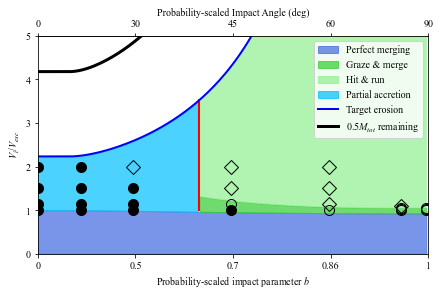

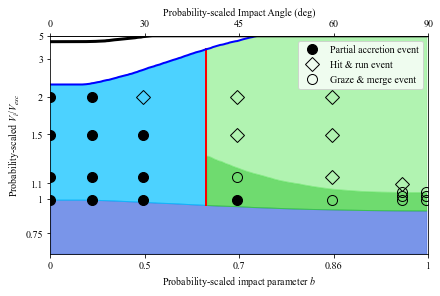

In [127]:
mlrmtot, outcome = collisionmap(mu, cstar, 1/6., np.asarray(varr6), np.asarray(np.arcsin(barr6)*180/np.pi), ymax=ymax, ymin=ymin, vscale=velarr, outcomes=typearr6)

In [ ]:
## trying with realistic rho and vesc values


2.0